In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections

In [21]:
plt.style.use('grayscale')

# Functions

In [12]:
def chao_wor(x, q):
    '''
    Chao1 without replacement
    See https://www.karsdorp.io/posts/20220323122150-estimating_richness_under_sampling_without_replacement/
    '''
    x = x[x > 0]
    n = x.sum() # sample size
    t = len(x)  # number of unique items
    f1 = (x == 1).sum() # number of singletons
    f2 = (x == 2).sum() # number of doubletons
    return int(t + (f1**2) / ((n / (n - 1)) * 2*f2 + (q / (1 - q)) * f1))


# Loading Data

In [2]:
df = pd.read_csv('../data/raw/vocapture.csv')
df.head()

,vocop_id,disambiguated_person,person_cluster_id,date_begin_contract,outward_voyage_id
0,104944,1.0,415682.0,1700-05-05,92895
1,104945,1.0,406243.0,1700-05-05,92895
2,104946,1.0,1.0,1700-05-05,92895
3,104947,1.0,77235.0,1700-05-05,92895
4,104948,1.0,65732.0,1700-05-05,92895


__vocop_id__: the unique id for each contract \
__disambiguated_person__: indicates whether the person is disambiguated (0 = no, 1 = yes). \
__person_cluster_id__: id that refers to unique person. If a person is disambiguated, multiple contracts can belong to one person \
__date_begin_contract__: start date of contract \
__outward_voyage_id__: unique id of outward voyage. 

In [3]:
print(f'total number of contracts: {df.shape[0]}')

total number of contracts: 774200


In [4]:
nans = df['date_begin_contract'].isnull().sum()
print(f'number of nans in date field: {nans}')
df = df.dropna(subset='date_begin_contract')

number of nans in date field: 257


In [9]:
#only select disambiguated records
records = df.loc[df['disambiguated_person'] == 1]['person_cluster_id'].astype(int).values
print(f'number of disambiguated records: {len(records)}')

number of disambiguated records: 546973


In [5]:
# construct year variable as Pandas is notoriously bad at working with dates before 1643

df['year'] = df['date_begin_contract'].str.split('-', expand=True)[0].astype(int)
df.sort_values(by='year', inplace=True)

In [36]:
df.groupby(pd.Grouper(key='year'))['date_begin_contract'].count()[120:150]

year
1775    10624
1776     8177
1777     6877
1778     4717
1779     7936
1780     5694
1781     1500
1782     3884
1783     7986
1784     8189
1785     6999
1786     8123
1787    10223
1788     9114
1789     6373
1790     7393
1791     7202
1792     5521
1793     5114
1794      977
Name: date_begin_contract, dtype: int64

## plot time series




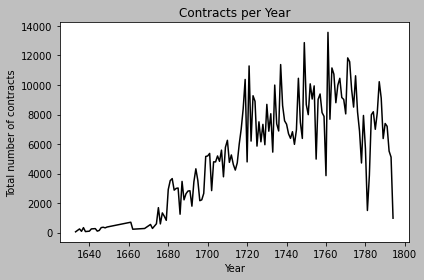

In [26]:
df.groupby(pd.Grouper(key='year'))['date_begin_contract'].count().plot()
plt.xlabel('Year')
plt.ylabel('Total number of contracts')
plt.title('Contracts per Year')
plt.tight_layout()
plt.savefig('../figures/total_contracts.png', dpi=300)

In [290]:
df.groupby(['outward_voyage_id'])['person_cluster_id'].count().median()

181.0

Given that there were 4,352 voyages, we can make estimate the observed number of sailors (4,352 * 181): 787,712. 

In [291]:
V = 787712



In [10]:
counts = np.array(list(collections.Counter(records).values()))
N, V_obs = counts.sum(), counts.shape[0]

#N, V = len(records), len(np.unique(records))
print(f"The archive consists of N={N} records and V_obs={V_obs} unique sailors.")

The archive consists of N=546973 records and V_obs=460274 unique sailors.


In [14]:
q = N / 787712 
print(q)

0.6943819568573286


In [15]:
chao_wor(counts, q)

621657

## per 25 years

In [16]:
date_ranges = []
x = 1633
y = 0
while y < 1795:
    y = x + 25
    if y > 1795:
        y = 1795
    date_ranges.append((x, y))
    x = y


date_ranges


[(1633, 1658),
 (1658, 1683),
 (1683, 1708),
 (1708, 1733),
 (1733, 1758),
 (1758, 1783),
 (1783, 1795)]

In [18]:
DAS_voyages = [468, 586, 620, 884, 848, 718, 383]

In [19]:
estimates = []
V_observations = []
for index, date in enumerate(date_ranges):
    print(date)
    df_slice = df[df['year'].between(date[0], date[1])]

    mean_sailors = int(df_slice.groupby(['outward_voyage_id'])['person_cluster_id'].count().mean())
    print(f'mean number of sailors:{mean_sailors}')
    V = DAS_voyages[index] * mean_sailors
    records = df_slice.loc[df_slice['disambiguated_person'] == 1]['person_cluster_id'].astype(int).values
    counts = np.array(list(collections.Counter(records).values()))
    N, V_obs = counts.sum(), counts.shape[0]
    V_observations.append(V_obs)
    print(f'records: {len(records)}')
    print(f'true sailors:{V}')
    q = len(records) / V
    print(q)
    estimate = chao_wor(counts, q)
    print(f'unique_sailors: {estimate}')
    estimates.append(estimate)
    

(1633, 1658)
mean number of sailors:145
records: 2471
true sailors:67860
0.03641320365458296
unique_sailors: 52055
(1658, 1683)
mean number of sailors:74
records: 6662
true sailors:43364
0.15362973895397103
unique_sailors: 40412
(1683, 1708)
mean number of sailors:124
records: 58971
true sailors:76880
0.7670525494276795
unique_sailors: 68884
(1708, 1733)
mean number of sailors:157
records: 135426
true sailors:138788
0.9757760036890798
unique_sailors: 116205
(1733, 1758)
mean number of sailors:186
records: 155596
true sailors:157728
0.9864830594441063
unique_sailors: 136287
(1758, 1783)
mean number of sailors:219
records: 153145
true sailors:157242
0.9739446203940423
unique_sailors: 131645
(1783, 1795)
mean number of sailors:177
records: 54152
true sailors:67791
0.7988081013703884
unique_sailors: 59365


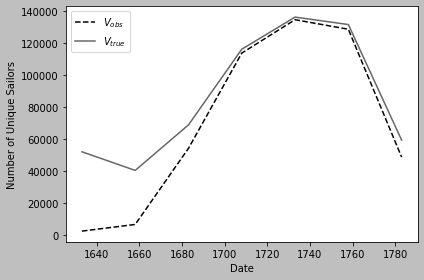

In [29]:
labels = [x[0] for x in date_ranges]

plt.plot(labels, V_observations, label='$V_{obs}$', linestyle='dashed')
plt.plot(labels, estimates, label='$V_{true}$')
plt.xlabel('Date')
plt.ylabel('Number of Unique Sailors')
plt.legend()
plt.tight_layout()
plt.savefig('../figures/25year_plot.png', dpi=300)